<a href="https://colab.research.google.com/github/Allan19k/Machine-Learning/blob/main/milk_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
print("GPU available:", torch.cuda.is_available())


GPU available: False


In [2]:
!pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 922.2/922.2 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [3]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle datasets download -d lawrencejembere/cow-images-for-milk-yield-prediction -p /content/dataset --unzip


Dataset URL: https://www.kaggle.com/datasets/lawrencejembere/cow-images-for-milk-yield-prediction
License(s): CC-BY-SA-4.0
100% 12.9G/12.9G [02:28<00:00, 107MB/s]
100% 12.9G/12.9G [02:28<00:00, 93.2MB/s]


In [5]:
import os
import pandas as pd
import shutil
from sklearn.model_selection import train_test_split

# 1. Cargar y renombrar el CSV
csv_path = "/content/dataset/train_data.csv"
df = pd.read_csv(csv_path, delimiter=";", header=None)
df.columns = ['milk_yield', 'img_1', 'img_2']  # Renombrar columnas

# 2. Buscar imágenes en todas las subcarpetas (A, B, G, M, etc.)
dataset_root = "/content/dataset"
image_paths = []
for root, dirs, files in os.walk(dataset_root):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(os.path.join(root, file))

# Crear diccionario de imágenes disponibles {nombre_imagen: ruta_completa}
available_images = {os.path.basename(path).strip(): path for path in image_paths}

In [6]:
# 3. Definir carpetas de clasificación
output_folders = {
    "low_yield": "/content/dataset/low_yield",
    "medium_yield": "/content/dataset/medium_yield",
    "high_yield": "/content/dataset/high_yield"
}

# Crear carpetas si no existen
for folder in output_folders.values():
    os.makedirs(folder, exist_ok=True)

# 4. Umbrales de producción (ajustar según tus datos)
low_threshold = 2316
high_threshold = 13843

# 5. Copiar imágenes a carpetas correspondientes
for idx, row in df.iterrows():
    img_name = str(row['img_1']).strip()  # Usar img_1 (o img_2 si es necesario)
    yield_value = row['milk_yield']

    # Buscar la imagen en todas las subcarpetas
    src_path = available_images.get(img_name)

    if not src_path:
        print(f"⚠️ Imagen no encontrada: {img_name}")
        continue

    # Determinar categoría
    if yield_value <= low_threshold:
        dest_folder = output_folders["low_yield"]
    elif yield_value <= high_threshold:
        dest_folder = output_folders["medium_yield"]
    else:
        dest_folder = output_folders["high_yield"]

    # Copiar imagen
    shutil.copy(src_path, os.path.join(dest_folder, img_name))

print("✅ Imágenes organizadas correctamente.")

⚠️ Imagen no encontrada: 17177R (2).JPG
⚠️ Imagen no encontrada: B19034R (2).JPG
⚠️ Imagen no encontrada: M18088R (2).JPG
✅ Imágenes organizadas correctamente.


In [57]:
import os

# Revisar cuántas imágenes hay en cada categoría
for category in ["low_yield", "medium_yield", "high_yield"]:
    folder = f"/content/dataset/{category}"
    num_images = len(os.listdir(folder))
    print(f"{category}: {num_images} imágenes")

low_yield: 301 imágenes
medium_yield: 994 imágenes
high_yield: 298 imágenes


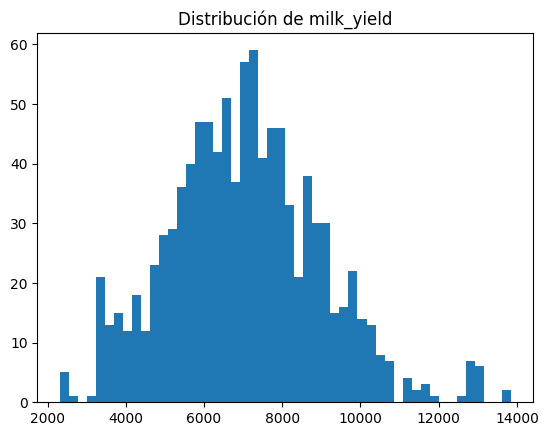

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar datos
csv_path = "/content/dataset/train_data.csv"
df = pd.read_csv(csv_path, delimiter=";", header=None)
df.columns = ['milk_yield', 'img_1', 'img_2']

# Analizar distribución
plt.hist(df["milk_yield"], bins=50)
plt.title("Distribución de milk_yield")
plt.show()

In [49]:
low_threshold = df["milk_yield"].quantile(0.3)  # Ej: 30% inferior
high_threshold = df["milk_yield"].quantile(0.7)  # Ej: 30% superior

In [50]:
# Filtrar datos para cada categoría
low_df = df[df["milk_yield"] <= low_threshold]
medium_df = df[(df["milk_yield"] > low_threshold) & (df["milk_yield"] <= high_threshold)]
high_df = df[df["milk_yield"] > high_threshold]

# Limitar medium_yield al tamaño de las otras categorías
max_samples = min(len(low_df), len(high_df), 40)  # Ajusta según necesidad
medium_df = medium_df.sample(max_samples, random_state=42)

In [51]:
output_folders = {
    "low_yield": "/content/dataset/low_yield",
    "medium_yield": "/content/dataset/medium_yield",
    "high_yield": "/content/dataset/high_yield"
}

for folder in output_folders.values():
    os.makedirs(folder, exist_ok=True)

# Copiar imágenes balanceadas
def copy_images(df_category, category_name):
    for idx, row in df_category.iterrows():
        img_name = str(row["img_1"]).strip()
        src_path = available_images.get(img_name)
        if src_path:
            shutil.copy(src_path, os.path.join(output_folders[category_name], img_name))

copy_images(low_df, "low_yield")
copy_images(medium_df, "medium_yield")
copy_images(high_df, "high_yield")

In [52]:
for category in output_folders:
    print(f"{category}: {len(os.listdir(output_folders[category]))} imágenes")

low_yield: 301 imágenes
medium_yield: 994 imágenes
high_yield: 298 imágenes


In [53]:
import os
import numpy as np
import pandas as pd
import shutil
from sklearn.model_selection import train_test_split

# Rutas de las carpetas originales
folders = {
    "low_yield": "/content/dataset/low_yield",
    "medium_yield": "/content/dataset/medium_yield",
    "high_yield": "/content/dataset/high_yield"
}

# Crear carpetas balanceadas
balanced_folder = "/content/dataset/balanced"
os.makedirs(balanced_folder, exist_ok=True)

for category in folders:
    # Ruta de la categoría original
    original_path = folders[category]
    # Ruta de la categoría balanceada
    balanced_path = os.path.join(balanced_folder, category)
    os.makedirs(balanced_path, exist_ok=True)

    # Listar imágenes originales
    all_images = os.listdir(original_path)

    # Submuestreo si hay más de 300 imágenes
    if len(all_images) > 300:
        selected_images = np.random.choice(all_images, 300, replace=False)
    # Sobremuestreo si hay menos de 300
    else:
        num_repeats = 300 // len(all_images) + 1
        repeated_images = all_images * num_repeats
        selected_images = repeated_images[:300]

    # Copiar imágenes a la carpeta balanceada
    for img in selected_images:
        src = os.path.join(original_path, img)
        dst = os.path.join(balanced_path, img)
        shutil.copy(src, dst)

    print(f"{category}: {len(os.listdir(balanced_path))} imágenes")

low_yield: 302 imágenes
medium_yield: 507 imágenes
high_yield: 300 imágenes


In [54]:
# Dividir cada categoría balanceada
for category in ["low_yield", "medium_yield", "high_yield"]:
    category_path = os.path.join(balanced_folder, category)
    all_images = os.listdir(category_path)

    # Dividir en 75% train (225) y 25% test (75) - Ajusta según tus necesidades
    train, test = train_test_split(all_images, test_size=75, random_state=42)

    # Crear subcarpetas
    os.makedirs(os.path.join(category_path, "train"), exist_ok=True)
    os.makedirs(os.path.join(category_path, "test"), exist_ok=True)

    # Mover imágenes
    for img in train:
        shutil.move(
            os.path.join(category_path, img),
            os.path.join(category_path, "train", img)
        )
    for img in test:
        shutil.move(
            os.path.join(category_path, img),
            os.path.join(category_path, "test", img)
        )

Error: Cannot move a directory '/content/dataset/balanced/low_yield/train' into itself '/content/dataset/balanced/low_yield/train/train'.

In [55]:
import os

balanced_folder = "/content/dataset/balanced"
categories = ["low_yield", "medium_yield", "high_yield"]

for category in categories:
    category_path = os.path.join(balanced_folder, category)
    num_images = len(os.listdir(category_path))
    print(f"{category}: {num_images} imágenes")

low_yield: 137 imágenes
medium_yield: 507 imágenes
high_yield: 300 imágenes


In [58]:
for category in categories:
    train_path = os.path.join(balanced_folder, category, "train")
    test_path = os.path.join(balanced_folder, category, "test")

    print(f"\n{category}:")
    print(f"  Train: {len(os.listdir(train_path))} imágenes")
    print(f"  Test: {len(os.listdir(test_path))} imágenes")


low_yield:
  Train: 279 imágenes
  Test: 91 imágenes

medium_yield:
  Train: 676 imágenes
  Test: 75 imágenes

high_yield:
  Train: 223 imágenes
  Test: 75 imágenes


In [59]:
import os
import shutil
import numpy as np

balanced_folder = "/content/dataset/balanced"

# Limpiar carpeta balanceada (ejecutar solo una vez)
shutil.rmtree(balanced_folder, ignore_errors=True)
os.makedirs(balanced_folder, exist_ok=True)

# Función para balancear cualquier categoría a 300 imágenes
def balance_category(source_folder, target_folder, n_samples=300):
    os.makedirs(target_folder, exist_ok=True)
    all_images = os.listdir(source_folder)

    # Submuestreo si hay más de 300 imágenes
    if len(all_images) > n_samples:
        selected_images = np.random.choice(all_images, n_samples, replace=False)
    # Sobremuestreo si hay menos (repitiendo imágenes)
    else:
        num_repeats = (n_samples // len(all_images)) + 1
        selected_images = np.tile(all_images, num_repeats)[:n_samples]

    # Copiar imágenes balanceadas
    for img in selected_images:
        src = os.path.join(source_folder, img)
        dst = os.path.join(target_folder, img)
        shutil.copy(src, dst)
    return len(os.listdir(target_folder))

# Aplicar a cada categoría
balance_category("/content/dataset/low_yield", f"{balanced_folder}/low_yield", 300)
balance_category("/content/dataset/medium_yield", f"{balanced_folder}/medium_yield", 300)
balance_category("/content/dataset/high_yield", f"{balanced_folder}/high_yield", 300)

298

In [60]:
from sklearn.model_selection import train_test_split

for category in ["low_yield", "medium_yield", "high_yield"]:
    category_path = os.path.join(balanced_folder, category)
    all_images = os.listdir(category_path)

    # Dividir en 75% train y 25% test
    train, test = train_test_split(all_images, test_size=0.25, random_state=42)

    # Crear subcarpetas
    os.makedirs(os.path.join(category_path, "train"), exist_ok=True)
    os.makedirs(os.path.join(category_path, "test"), exist_ok=True)

    # Mover imágenes (usar copy si ejecutas múltiples veces)
    for img in train:
        shutil.move(os.path.join(category_path, img), os.path.join(category_path, "train", img))
    for img in test:
        shutil.move(os.path.join(category_path, img), os.path.join(category_path, "test", img))

In [61]:
for category in ["low_yield", "medium_yield", "high_yield"]:
    train_dir = os.path.join(balanced_folder, category, "train")
    test_dir = os.path.join(balanced_folder, category, "test")

    print(f"\n{category}:")
    print(f"  Train: {len(os.listdir(train_dir))} imágenes")
    print(f"  Test: {len(os.listdir(test_dir))} imágenes")


low_yield:
  Train: 225 imágenes
  Test: 75 imágenes

medium_yield:
  Train: 225 imágenes
  Test: 75 imágenes

high_yield:
  Train: 223 imágenes
  Test: 75 imágenes


In [64]:
!pip install roboflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.1/83.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 12.0 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


In [65]:
from roboflow import Roboflow

rf = Roboflow(api_key="7OMBRpJ0vTpeuWJknv9s")
# Ejemplo: rf = Roboflow(api_key="1234abcd...")


In [66]:
project = rf.workspace("cowsegmentation").project("segmentacion-de-vacas")

loading Roboflow workspace...
loading Roboflow project...
